# Motif LFC x State

Effect of each motif on adding to some specific background (random sequences for positive motifs, existing peaks for negative).

**Inputs**:
1. List of motifs with their corresponding PWMs-- deduping will be performed here.
2. Cell state specific models

In [1]:
import numpy as np
import editdistance
from collections import Counter, defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyfaidx
import tqdm
import math

In [2]:
import sys

import keras
from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [3]:
sys.path.append("/users/surag/kundajelab/surag-scripts/misc/")
import one_hot

## Load Input Data

In [4]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

### TF List

In [5]:
with open("../../analysis/20200723_motif_annotation/pwm_hits/20201020_n62402/overlap.no_iPSC.no_clump.merged.500/tfs.txt") as f:
    tf_list = [x.strip() for x in f]

In [6]:
tf_list[:10]

['AP2A_HUMAN.H11MO.0.A',
 'AP2A_MOUSE.H11MO.0.A',
 'AP2C_HUMAN.H11MO.0.A',
 'Ascl2.mouse_bHLH_1',
 'ATF1_MOUSE.H11MO.0.B',
 'BATF+JUN_MA0462.1',
 'CEBPA_MA0102.3',
 'CEBPB_MOUSE.H11MO.0.A',
 'CREB1_MA0018.3',
 'CREB3_bZIP_1']

In [7]:
len(tf_list)

123

### Load TF PWMs

In [8]:
mots = {}
for x in tf_list:
    mots[x] = np.loadtxt("/srv/www/kundaje/surag/resources/motif_archetypes/pfm/{}.pfm".format(x))

In [9]:
len(mots)

123

In [10]:
consensus_seqs = {}
for x in mots:
    consensus_seqs[x] = ''.join([["A","C","G","T"][i] for i in np.argmax(mots[x], 0)])

In [11]:
consensus_seqs['AP2A_HUMAN.H11MO.0.A']

'ATGCCCTGAGGCCAT'

In [12]:
consensus_seqs['AP2C_HUMAN.H11MO.0.A']

'ATGCCCTGAGGCCA'

In [13]:
def revcomp(x):
    RC  = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    return ''.join([RC[y] for y in x])[::-1]

In [85]:
non_redundant_seqs = {}

MAX_EDIT_DIST = 1
MAX_LEN_DIFF = 3 # don't compare strings if they differ by >= this number

for x in consensus_seqs:
    # also do a rolling edit distance calculation

    match = None
    contained = False
    for y in non_redundant_seqs:
        if abs(len(non_redundant_seqs[y])-len(consensus_seqs[x])) <= MAX_LEN_DIFF:
            y_is_shorter = len(non_redundant_seqs[y]) < len(consensus_seqs[x])

            shorter_seq = non_redundant_seqs[y] if y_is_shorter else consensus_seqs[x]
            longer_seq = non_redundant_seqs[y] if not y_is_shorter else consensus_seqs[x]

            fwd_edit_dists = [editdistance.eval(shorter_seq, longer_seq[i:i+len(shorter_seq)]) \
                              for i in range(len(longer_seq)-len(shorter_seq)+1)]
            rev_edit_dists = [editdistance.eval(revcomp(shorter_seq), longer_seq[i:i+len(shorter_seq)]) \
                              for i in range(len(longer_seq)-len(shorter_seq)+1)]

            if min(min(fwd_edit_dists), min(rev_edit_dists)) <= MAX_EDIT_DIST:
                if y_is_shorter:
                    contained = y
                else:
                    # replace y with x
                    match = y
    
    # check these subs to make sure they're OK
#     if contained or match:
#         print("{}\t{}\t{}\n".format(x, contained, match))
        
    if not contained:
        if match:
            del non_redundant_seqs[match]
        non_redundant_seqs[x] = consensus_seqs[x]

In [86]:
len(non_redundant_seqs)

67

In [87]:
non_redundant_seqs

{'AP2A_MOUSE.H11MO.0.A': 'ATGGCCTGAGGC',
 'Ascl2.mouse_bHLH_1': 'AGCAGCTGCT',
 'ATF1_MOUSE.H11MO.0.B': 'CTGACGTCAC',
 'BATF+JUN_MA0462.1': 'GAAATGACTCA',
 'CEBPA_MA0102.3': 'ATTGCACAATA',
 'CEBPB_MOUSE.H11MO.0.A': 'GGTTGTGCAAT',
 'CTCFL_HUMAN.H11MO.0.A': 'GCCGCCAGGGGGCGCCG',
 'CTCF_MA0139.1': 'TGGCCACCAGGGGGCGCTA',
 'ELK4_MA0076.2': 'CCACTTCCGGC',
 'ETS1_HUMAN.H11MO.0.A': 'AGACAGGAAGTGG',
 'ETV1_HUMAN.H11MO.0.A': 'GGCCGGAAGTG',
 'FOSL2+JUNB_MA1138.1': 'GATGACTCAT',
 'Foxc1.mouse_forkhead_2': 'ATAAACA',
 'FOXC2_MA0846.1': 'TAAGTAAACAAA',
 'FOXL2_MOUSE.H11MO.0.C': 'TGTTTACATTT',
 'Gabpa_MA0062.2': 'CCGGAAGTGGC',
 'IRF1_MA0050.2': 'TTTTACTTTCACTTTCACTTT',
 'IRF1_MOUSE.H11MO.0.A': 'GAAAGTGAAAGTGAAAGTAA',
 'JDP2_MA0656.1': 'GATGACGTCATC',
 'JUN_MOUSE.H11MO.0.A': 'GGTGAGTCAC',
 'KAISO_MOUSE.H11MO.0.B': 'CAAATCTCGCGAGAA',
 'KLF3_HUMAN.H11MO.0.B': 'GGGGAGGGGCGGGGCCGGG',
 'KLF4_HUMAN.H11MO.0.A': 'AGGGTGTGGC',
 'KLF5_MA0599.1': 'GCCCCGCCCC',
 'MAZ_HUMAN.H11MO.0.A': 'GGGGGAGGGGGGGGGGGGGGGG',
 'MS

### Models

In [88]:
MODEL_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/"

In [89]:
#  "old" cluster IDs
CELL_STATES = [5,12,10, 13,4,8,2, 7,1,16]

In [100]:
# load models
models = dict()
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    for x in CELL_STATES:
        model_path = list(Path(MODEL_BASE).glob("cluster_idx{}/2021*/*.h5".format(x)))
        assert(len(model_path)==1)
        model_path = str(model_path[0])
        models[x] = keras.models.load_model(model_path)

In [101]:
MODEL_INP_LEN = models[CELL_STATES[0]].input_shape[0][1]
MODEL_OUT_LEN = models[CELL_STATES[0]].output_shape[0][1]
print(MODEL_INP_LEN)
print(MODEL_OUT_LEN)

2346
2000


### Peaks

For anti-accessibility motifs

In [102]:
PEAKS_PATH = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx{}/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz"

In [103]:
cell_state_peaks = defaultdict()

for i in CELL_STATES:
    cell_state_peaks[i] = pd.read_csv(PEAKS_PATH.format(i),
                       sep='\t',
                       names=['chr', 'start', 'end' ,'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'summit'])

## Process

In [104]:
CHRS = ["chr"+str(x) for x in list(range(1,23)) + ["X", "Y"]]
CHR_LENS = [len(hg38[x]) for x in CHRS]

In [105]:
# select bunch of random locs
random_positions = []
for x in range(128*2):
    cur_chr = np.random.choice(CHRS, p=np.array(CHR_LENS)/sum(CHR_LENS))
    cur_pos = np.random.choice(len(hg38[cur_chr])-MODEL_INP_LEN//2)
    random_positions.append((cur_chr, cur_pos))

In [106]:
BATCH_SIZE = 128

In [107]:
# random seqs
random_pred_counts = defaultdict(list)

for cell_state in CELL_STATES:
    for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
        cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        cur_raw_seqs = []
        for j, r in enumerate(cur_seqs):        
            cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))

        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)

        cur_pred = models[cell_state].predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])
        random_pred_counts[cell_state].append(cur_pred[1])
    
    random_pred_counts[cell_state] = np.vstack(random_pred_counts[cell_state]).ravel()

100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


In [108]:
def mod_sequence(s, rep, motif_start):
    return s[:motif_start] + rep + s[motif_start+len(rep):]  #+ "ATTTGCATAACAATG" + s[motif_end+115:]

In [109]:
mod_sequence("0123456789", "ABC", 4)

'0123ABC789'

In [110]:
len(non_redundant_seqs)

67

In [111]:
# with motifs in middle
motif_pred_counts = defaultdict(lambda: defaultdict(list))

for cell_state in CELL_STATES:
    for y in tqdm.tqdm(non_redundant_seqs):
        for i in range(math.ceil(len(random_positions)/BATCH_SIZE)):
            cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            cur_raw_seqs = []
            for j, r in enumerate(cur_seqs):        
                cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
                cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], non_redundant_seqs[y], MODEL_INP_LEN//2)

            cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)

            cur_pred = models[cell_state].predict([cur_raw_seqs, 
                           np.zeros((cur_raw_seqs.shape[0],1)), 
                           np.zeros((cur_raw_seqs.shape[0],2000,2))])
            motif_pred_counts[cell_state][y].append(cur_pred[1])

        motif_pred_counts[cell_state][y] = np.vstack(motif_pred_counts[cell_state][y]).ravel()

100%|██████████| 67/67 [00:42<00:00,  1.58it/s]


In [162]:
# LFC x state df
mots = []
cs = []
vals = []

for i,x in enumerate(CELL_STATES):
    for j,y in enumerate(non_redundant_seqs):
        mots.append(y.split(".")[0] + " ({})".format(non_redundant_seqs[y]))
        cs.append(x) 
        vals.append(np.median(motif_pred_counts[x][y] - random_pred_counts[x]))
        
lfc_x_state =  pd.DataFrame({"mots":mots,
                            "cell_states":cs,
                            "vals": vals})

In [163]:
MIN_THRESH = 0.1

to_plot = lfc_x_state.pivot('cell_states', 'mots', 'vals')
print("REMOVING")
print('\n'.join(to_plot.columns[(to_plot.max(0) <= MIN_THRESH)]))
to_plot = to_plot[to_plot.columns[(to_plot.max(0) > MIN_THRESH)]]
to_plot.index = pd.CategoricalIndex(to_plot.index, categories= CELL_STATES)
to_plot.sort_index(level=0, inplace=True)

REMOVING
Foxc1 (ATAAACA)
MYC_HUMAN (GCCACGTGCTC)
NFIB_MOUSE (CCTGGCAGC)
PRDM6_HUMAN (AAAAAGAAAAAAA)
Sox3_MA0514 (CCTTTGTTTT)
ZFX_MOUSE (GCCGAGGCCTGGGGCCCCC)


In [164]:
to_plot.shape

(10, 61)

In [165]:
non_redundant_seqs["CEBPB_MOUSE.H11MO.0.A"]

'GGTTGTGCAAT'

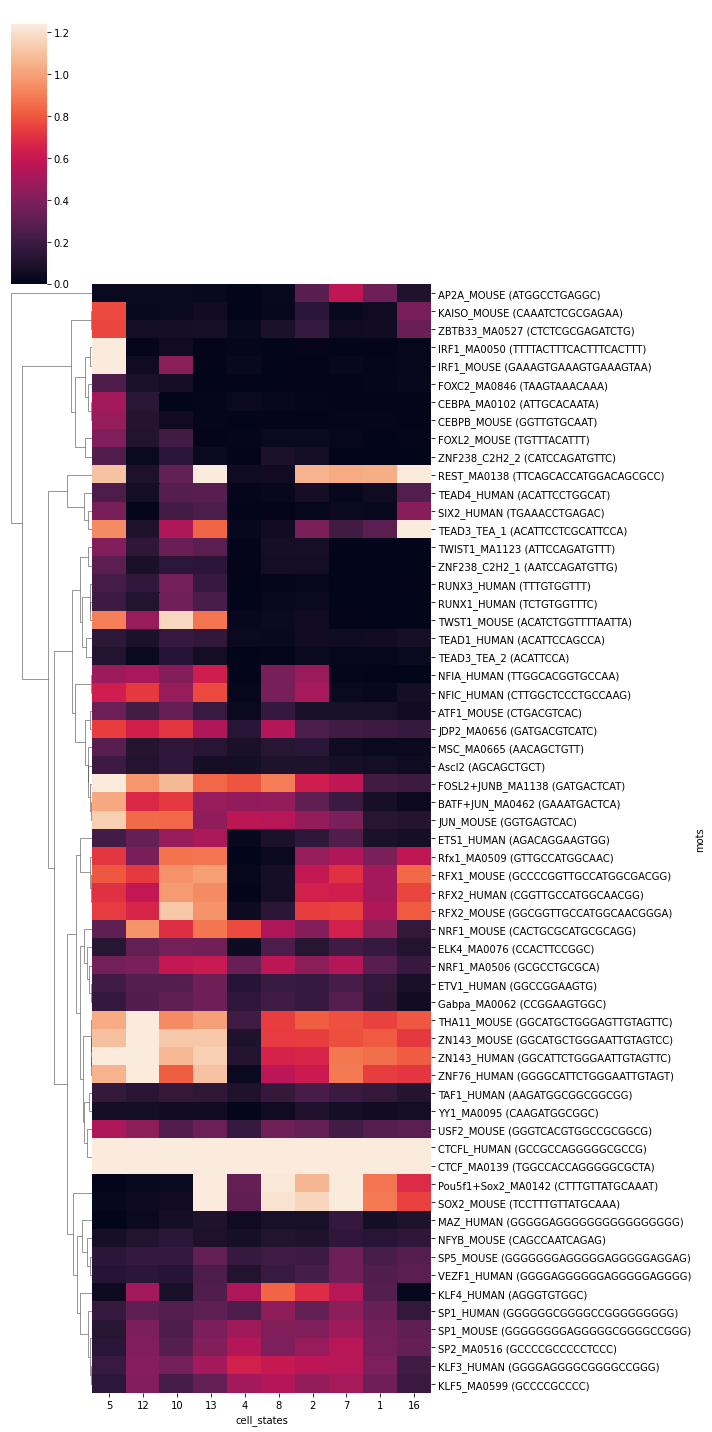

In [166]:
sns.clustermap(to_plot.T,
               metric='cosine',
               vmin=0, 
               vmax=np.quantile(lfc_x_state['vals'] , .95),
               col_cluster=False,
               row_cluster=True,
#                z_score=1,
               figsize=(10,20))

In [167]:
to_plot["IRF1_MA0050 (TTTTACTTTCACTTTCACTTT)"]

cell_states
5     1.993988
12    0.014116
10    0.050906
13    0.006806
4     0.012773
8     0.003199
2     0.011198
7    -0.004327
1     0.005226
16    0.014745
Name: IRF1_MA0050 (TTTTACTTTCACTTTCACTTT), dtype: float64

In [168]:
to_plot["FOXC2_MA0846 (TAAGTAAACAAA)"]

cell_states
5     0.255915
12    0.090661
10    0.069291
13   -0.007279
4     0.001718
8     0.001176
2     0.005631
7     0.007082
1     0.009981
16    0.022603
Name: FOXC2_MA0846 (TAAGTAAACAAA), dtype: float64

In [169]:
to_plot["JUN_MOUSE (GGTGAGTCAC)"]

cell_states
5     1.146097
12    0.852014
10    0.844371
13    0.447958
4     0.577782
8     0.558712
2     0.457111
7     0.389924
1     0.129775
16    0.117410
Name: JUN_MOUSE (GGTGAGTCAC), dtype: float64

In [170]:
to_plot.to_csv("./LFC_x_state_intermediate/pos.random.bg.tsv", sep='\t')

### Negative Motifs

Add ZEB and ZBTB motifs to existing peaks, instead of random regions, to assess effect.

In [119]:
CELL_STATES

[5, 12, 10, 13, 4, 8, 2, 7, 1, 16]

In [120]:
cell_state_sampled_peaks = defaultdict()

for i in CELL_STATES:
    cell_state_sampled_peaks[i] = cell_state_peaks[i].sample(128*2)

In [121]:
# random seqs
cell_state_pred_counts = defaultdict(list)

for cell_state in CELL_STATES:
    for i in tqdm.tqdm(range(math.ceil(len(cell_state_sampled_peaks[cell_state])/BATCH_SIZE))):
        cur_seqs = cell_state_sampled_peaks[cell_state][i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        cur_raw_seqs = []
        for j, r in cur_seqs.iterrows():        
            cur_raw_seqs.append(str(hg38[r['chr']][r['start']+r['summit']-(MODEL_INP_LEN//2):r['start']+r['summit']+(MODEL_INP_LEN//2)]))

        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)

        cur_pred = models[cell_state].predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])
        cell_state_pred_counts[cell_state].append(cur_pred[1])
    
    cell_state_pred_counts[cell_state] = np.vstack(cell_state_pred_counts[cell_state]).ravel()

100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


In [122]:
anti_accs_motifs = {'ZEB':"CAGGTG",
                    'ZBTB':"GGGGTC"}

In [139]:
# with motifs in middle
anti_motif_pred_counts = defaultdict(lambda: defaultdict(list))

for cell_state in CELL_STATES:
    for y in tqdm.tqdm(anti_accs_motifs):
        for i in range(math.ceil(len(cell_state_sampled_peaks[cell_state])/BATCH_SIZE)):
            cur_seqs = cell_state_sampled_peaks[cell_state][i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            cur_raw_seqs = []
            for j, r in cur_seqs.iterrows():        
                cur_raw_seqs.append(str(hg38[r['chr']][r['start']+r['summit']-(MODEL_INP_LEN//2):r['start']+r['summit']+(MODEL_INP_LEN//2)]))
                cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], anti_accs_motifs[y], (MODEL_INP_LEN//2))

            cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)

            cur_pred = models[cell_state].predict([cur_raw_seqs, 
                           np.zeros((cur_raw_seqs.shape[0],1)), 
                           np.zeros((cur_raw_seqs.shape[0],2000,2))])
            anti_motif_pred_counts[cell_state][y].append(cur_pred[1])

        anti_motif_pred_counts[cell_state][y] = np.vstack(anti_motif_pred_counts[cell_state][y]).ravel()

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


In [171]:
# LFC x state df
mots = []
cs = []
vals = []

for i,x in enumerate(CELL_STATES):
    for j,y in enumerate(anti_accs_motifs):
        mots.append(y.split(".")[0] + "({})".format(anti_accs_motifs[y]))
        cs.append(x) 
        vals.append(np.median(anti_motif_pred_counts[x][y] - cell_state_pred_counts[x]))
        
lfc_x_state_anti =  pd.DataFrame({"mots":mots,
                            "cell_states":cs,
                            "vals": vals})

In [172]:
lfc_x_state_anti

,mots,cell_states,vals
0,ZEB(CAGGTG),5,-0.399256
1,ZBTB(GGGGTC),5,-0.208153
2,ZEB(CAGGTG),12,-0.166746
3,ZBTB(GGGGTC),12,-0.158129
4,ZEB(CAGGTG),10,-0.292655
5,ZBTB(GGGGTC),10,-0.122601
6,ZEB(CAGGTG),13,-0.146130
7,ZBTB(GGGGTC),13,-0.084335
8,ZEB(CAGGTG),4,-0.278754
9,ZBTB(GGGGTC),4,-0.372652


In [173]:
to_plot_anti = lfc_x_state_anti.pivot('cell_states', 'mots', 'vals')
to_plot_anti

mots,ZBTB(GGGGTC),ZEB(CAGGTG)
cell_states,,
1,-0.063329,-0.011112
2,-0.132843,-0.057671
4,-0.372652,-0.278754
5,-0.208153,-0.399256
7,-0.096162,-0.024569
8,-0.185643,-0.111580
10,-0.122601,-0.292655
12,-0.158129,-0.166746
13,-0.084335,-0.146130


In [174]:
to_plot_anti.to_csv("./LFC_x_state_intermediate/neg.random.bg.tsv", sep='\t')